## Rohde Schwarz Virtual Network Analyser

Example notebook for basic driver useage

- basic settings
- taking a frequency sweep
- spectroscopy mode for ZNB8

In [1]:
%matplotlib nbagg
import qcodes as qc

In [2]:
import qcodes.instrument_drivers.rohde_schwarz.ZNB20 as vna

In [3]:
v1 =vna.ZNB20('VNA', 'TCPIP0::172.20.3.94::inst0::INSTR')

Connected to: Rohde-Schwarz ZNB20-2Port (serial:1311601062101551, firmware:2.10) in 0.09s


### Basic Use
Default settings, VNA measures S21 and can perform frequency sweeps with given parameters

In [4]:
# basic settings available
v1.bandwidth(500)
v1.power(-50)

# functions: (all also have 'off')
v1.tooltip_on() # shows errors on intrument screen
v1.cont_meas_on() # instrument continiously sweeps frequency
v1.update_display_on() # shows measurement on instrument screen (slows it down a bit)
v1.rf_on() #turns on all ports 
v1.update_display_once()

In [5]:
# setting up frequency trace params (set here as sweep is hardware controlled)
v1.start(150e6)
v1.stop(800e6)
v1.avg(1)
v1.npts(71)

In [6]:
# getting a single trace
data = qc.Measure(v1.trace).run()
plot = qc.QtPlot(data.VNA_magnitude)
plot.save()

DataSet:
   mode     = DataMode.LOCAL
   location = '2016-11-19/19-55-35'
   <Type>   | <array_id>    | <array.name> | <array.shape>
   Measured | frequency     | frequency    | (71,)
   Measured | VNA_magnitude | magnitude    | (71,)
   Measured | VNA_phase     | phase        | (71,)
acquired at 2016-11-19 19:55:35


In [7]:
# qcodes loop
loop = qc.Loop(v1.power.sweep(-15,-2, 1)).each(v1.trace)
data = loop.get_data_set(name='testsweep')
plot = qc.QtPlot()
plot.add(data.VNA_magnitude)
_ = loop.with_bg_task(plot.update, plot.save).run()

DataSet:
   mode     = DataMode.LOCAL
   location = '2016-11-19/19-55-39_testsweep'
   <Type>   | <array_id>    | <array.name> | <array.shape>
   Setpoint | VNA_power_set | power        | (14,)
   Measured | frequency     | frequency    | (14, 71)
   Measured | VNA_magnitude | magnitude    | (14, 71)
   Measured | VNA_phase     | phase        | (14, 71)
started at 2016-11-19 19:55:43


<IPython.core.display.Javascript object>


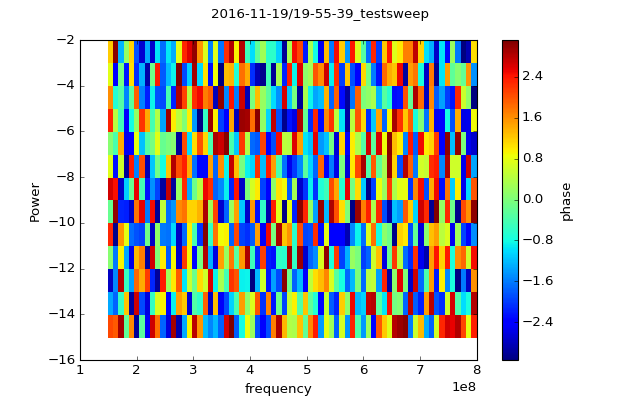

<IPython.core.display.Javascript object>


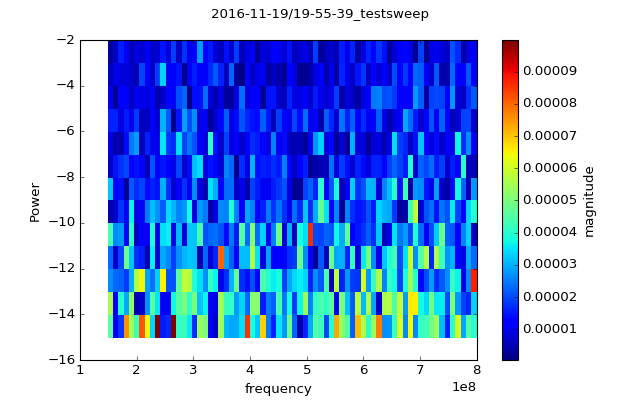

In [8]:
# plot results
qc.MatPlot(data.VNA_phase)
qc.MatPlot(data.VNA_magnitude)

### Spectroscopy Mode
This mode is useful for monitoring the response of a resonance whilst sweeping the frequency drive in a different range.

In this mode the VNA is assumed to have at least 3 ports (so actually for ZNB8...)
- Drives port 1 at a fixed frequency
- Drives port 3 which is swept by instrument in trace. 
- Measures the response at port 2 (as before)

In [9]:
# setting spec mode to 1
v1.spec_mode('on')

# by default the port 1 is now driven at the center frequency of the original sweep and at the same power
v1.fixed_freq(6.61262e9)
v1.fixed_pow(-55)

# set up sweep on port 3
v1.start(7.5e9)
v1.stop(8.5e9)
v1.avg(2)
v1.npts(501)
v1.power(-30)

# Measurement and loop can then be run exactly as above